In [1]:
import numpy as np
import pandas as pd
import yaml

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, roc_curve, roc_auc_score, auc, precision_recall_curve, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# Load the configuration file

In [2]:
with open("workspace/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

lame = config['lame']
path = f"{config['path_to_data']}/{lame}"

# Load the data

In [3]:
# Load the selected peaks in the region with the given frequency
peaks = pd.read_csv(f"{path}/results/mse_spectra_region.csv")

# Load the selected region pixels features
pixels = pd.read_csv(f"{path}/results/mse_pixels_region.csv")

# Plot the pixels densities extracted from the IHC images

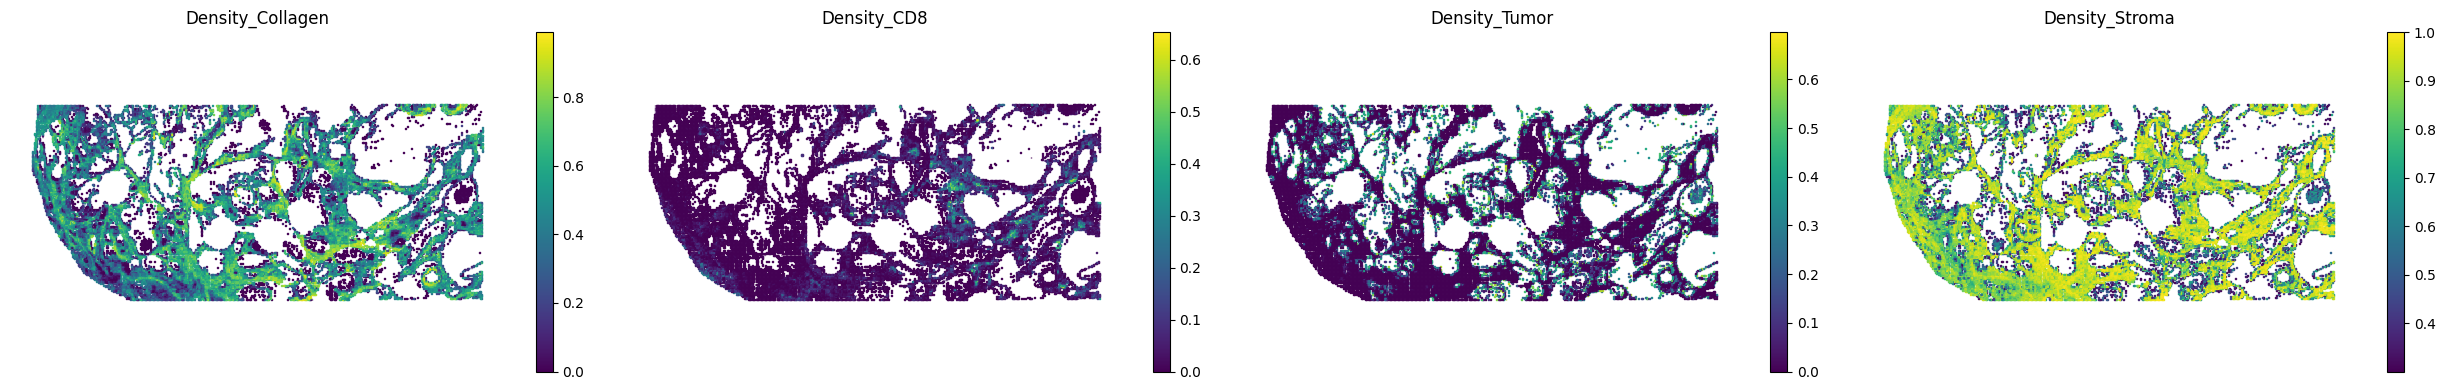

In [4]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

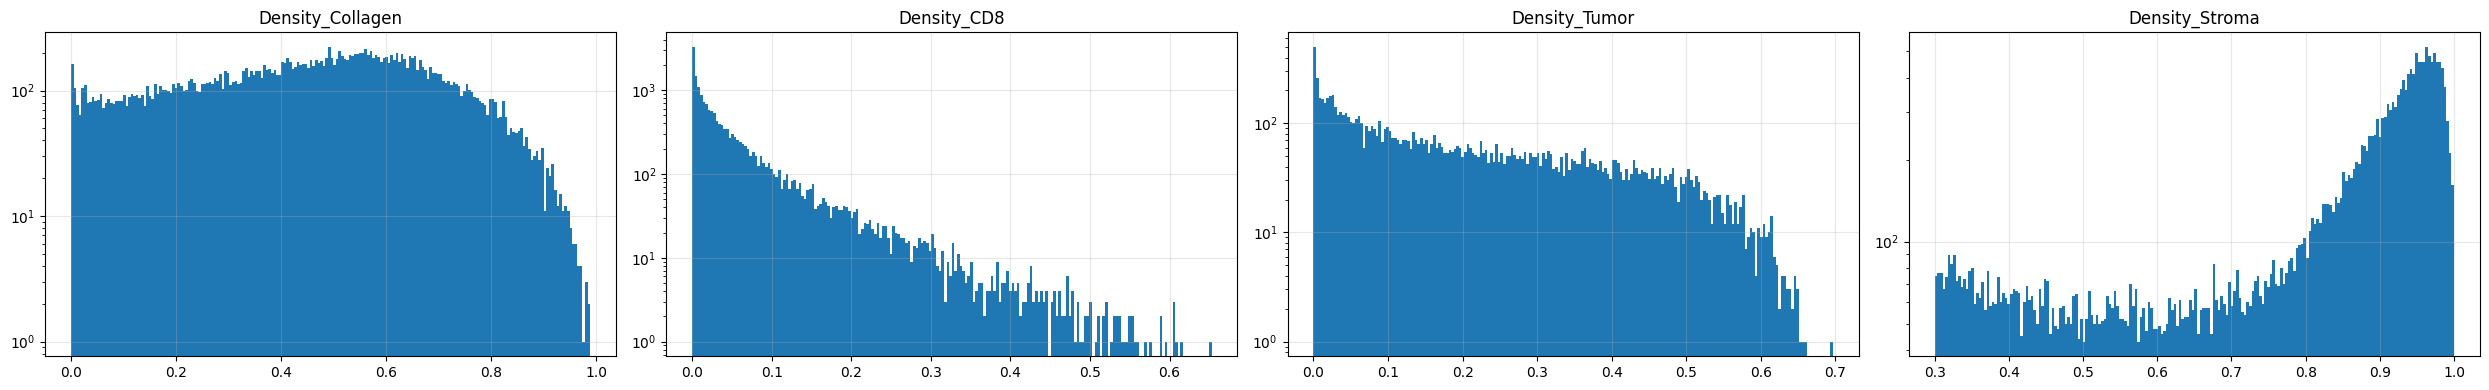

In [5]:
# Make a histogram of the pixel densities data
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)

for ax, density in zip(axs.flatten(), densities):
    ax.hist(pixels[density][pixels[density] != 0], bins=200)
    ax.set_title(density)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

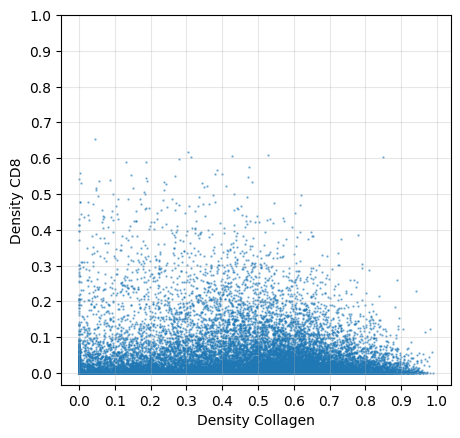

In [6]:
plt.scatter(x=pixels['Density_Collagen'], y=pixels['Density_CD8'], alpha=0.5, s=0.5)
plt.xlabel('Density Collagen')
plt.ylabel('Density CD8')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Define a threshold for the pixel densities, then plot the density thresholded masks

In [7]:
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

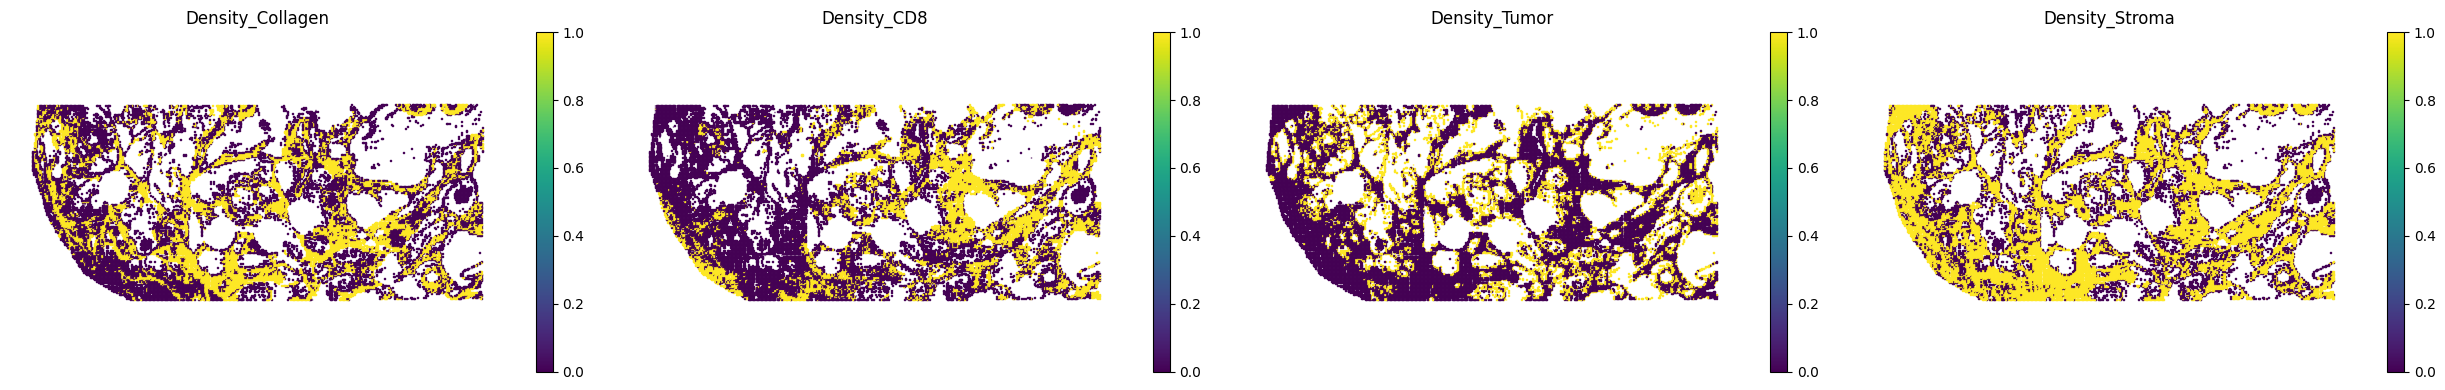

In [8]:
# plot the pixels densities with threshold
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density] > threshold[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

# Split the data into training and testing sets

In [9]:
# Sample data
X = peaks.values
y = pixels['Density_CD8'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform a linear regression

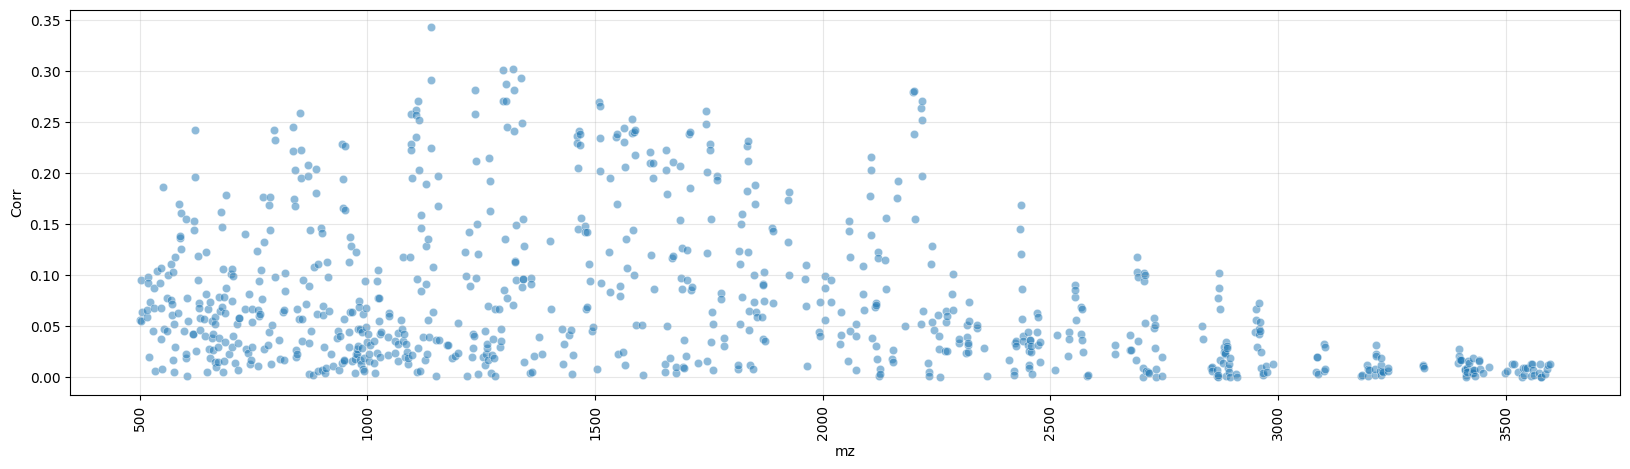

In [10]:
mse, r2 = [], []
for feature in X.T:

    # Reshape the data
    feature = feature.reshape(-1, 1)

    # Create a linear regression model
    model_reg = LinearRegression()

    # Train the model
    model_reg.fit(feature, y)

    # Make predictions
    y_pred = model_reg.predict(feature)

    # Compute R-squared
    r2_feature = model_reg.score(feature, y)

    # Compute the mean squared error
    mse_feature = mean_squared_error(y, model_reg.predict(feature))

    # Append the results
    mse.append(mse_feature)
    r2.append(r2_feature)

df_reg = pd.DataFrame({
    'mz': peaks.columns,
    'MSE': mse,
    'R2': r2,
    'Corr': np.sqrt(r2)
})

# Transform the mass data type to float
df_reg['mz'] = df_reg['mz'].astype(float).round(2)

# Plot the corr vs mass
plt.figure(figsize=(20, 5))
sns.scatterplot(x='mz', y='Corr', data=df_reg, alpha=0.5)
plt.xticks(rotation=90)
plt.grid(alpha=0.3)
plt.show()

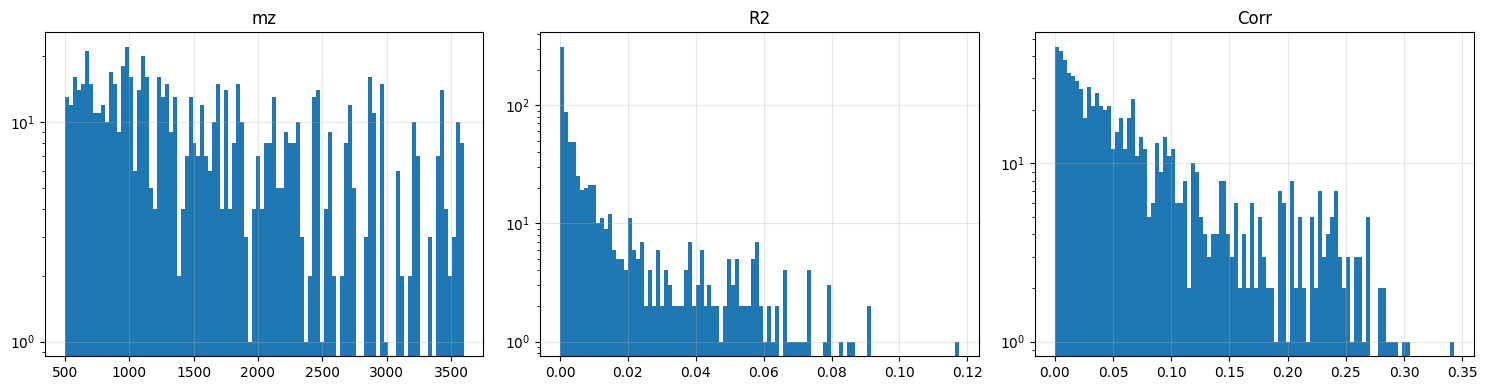

In [11]:
# Plot histograms of the MSE and R2 values
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

for ax, metric in zip(axs.flatten(), ['mz', 'R2', 'Corr']):
    ax.hist(df_reg[metric], bins=100)
    ax.set_title(metric)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

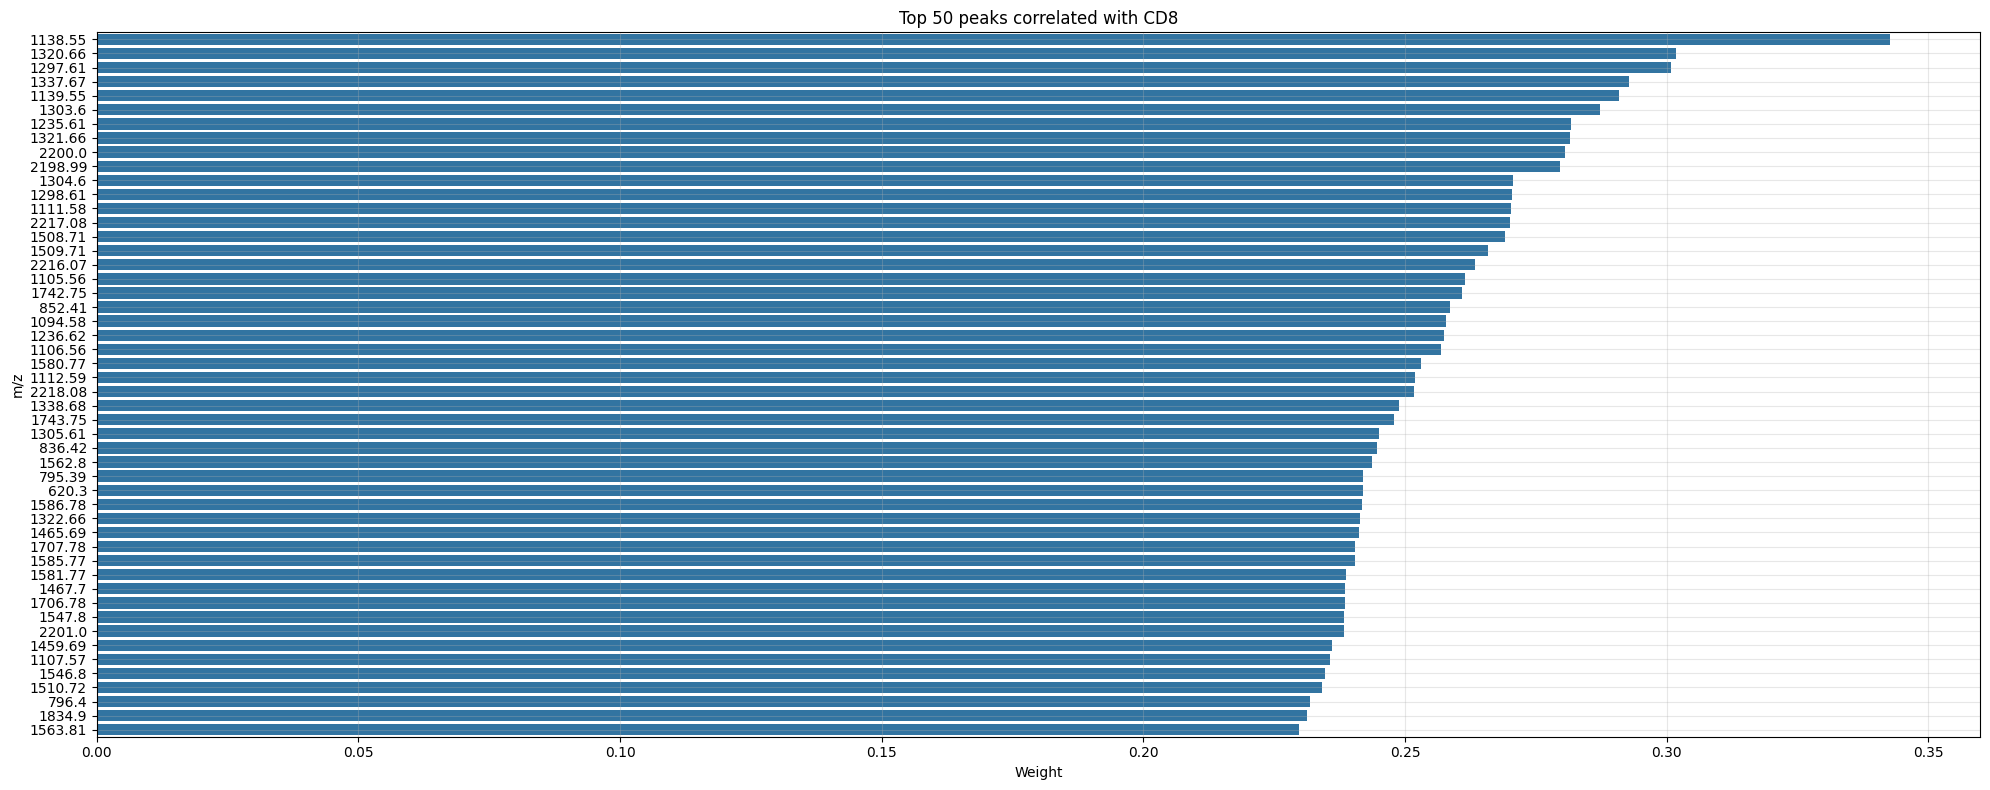

In [12]:
# Order the peaks by their weights
cd8_peaks_ordered = df_reg.sort_values(by='Corr', ascending=False)

# Transform the cd8_peaks datatypes
cd8_peaks_ordered['mz'] = cd8_peaks_ordered['mz'].round(2).astype(str)

# Plot the top 50 peaks
fig, ax = plt.subplots(1, 1, figsize=(20, 8), tight_layout=True)
sns.barplot(data=cd8_peaks_ordered.head(50), x='Corr', y='mz', orient="h", ax=ax)
ax.set_title("Top 50 peaks correlated with CD8")
ax.set_xlabel("Weight")
ax.set_ylabel("m/z")
ax.grid(alpha=0.3)

plt.show()

In [13]:
# Adjust the y values to be binary
y = pixels['Density_CD8'].values > threshold['Density_CD8']

# Create a logistic regression model for each peak
roc_aucs, sensitivities, specificities, precisions, precision_recall_aucs = [], [], [], [], []
for feature in X.T:
    # Reshape the data
    feature = feature.reshape(-1, 1)

    # Create a logistic regression model
    model_log = LogisticRegression()

    # Train the model
    model_log.fit(feature, y)

    # Make predictions
    y_pred = model_log.predict(feature)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, model_log.predict_proba(feature)[:, 1])

    # Compute the ROC AUC
    roc_auc = roc_auc_score(y, model_log.predict_proba(feature)[:, 1])

    # Compute the True Positives, True Negatives, False Positives and False Negatives
    true_positives = np.sum((y == 1) & (y_pred == 1))
    true_negatives = np.sum((y == 0) & (y_pred == 0))
    false_positives = np.sum((y == 0) & (y_pred == 1))
    false_negatives = np.sum((y == 1) & (y_pred == 0))

    # Compute the Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    # Calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y, model_log.predict_proba(feature)[:, 1])

    # Compute the AUC for the precision-recall curve
    precision_recall_auc = auc(recall, precision)

    # Calculate the intersection threshold
    intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

    # Append the results
    roc_aucs.append(roc_auc)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    precisions.append(precision_recall_auc)
    precision_recall_aucs.append(precision_recall_auc)

# Create a dataframe with the results
df_log = pd.DataFrame({
    'mz': peaks.columns,
    'ROC_AUC': roc_aucs,
    'Sensitivity': sensitivities,
    'Specificity': specificities,
    'Precision': precisions,
    'Precision_Recall_AUC': precision_recall_aucs
})

df_log

,mz,ROC_AUC,Sensitivity,Specificity,Precision,Precision_Recall_AUC
0,501.295932658,0.518546,0.0,1.0,0.643370,0.643370
1,502.240833484021,0.511524,0.0,1.0,0.655379,0.655379
2,503.267481376577,0.530979,0.0,1.0,0.629161,0.629161
3,504.253660199682,0.513832,0.0,1.0,0.636957,0.636957
4,515.32215692861,0.462770,0.0,1.0,0.304530,0.304530
...,...,...,...,...,...,...
812,3578.74187845021,0.502930,0.0,1.0,0.331975,0.331975
813,3587.81163406335,0.503324,0.0,1.0,0.341081,0.341081
814,3590.76155812443,0.498848,0.0,1.0,0.643479,0.643479
815,3592.80633020046,0.502366,0.0,1.0,0.646399,0.646399


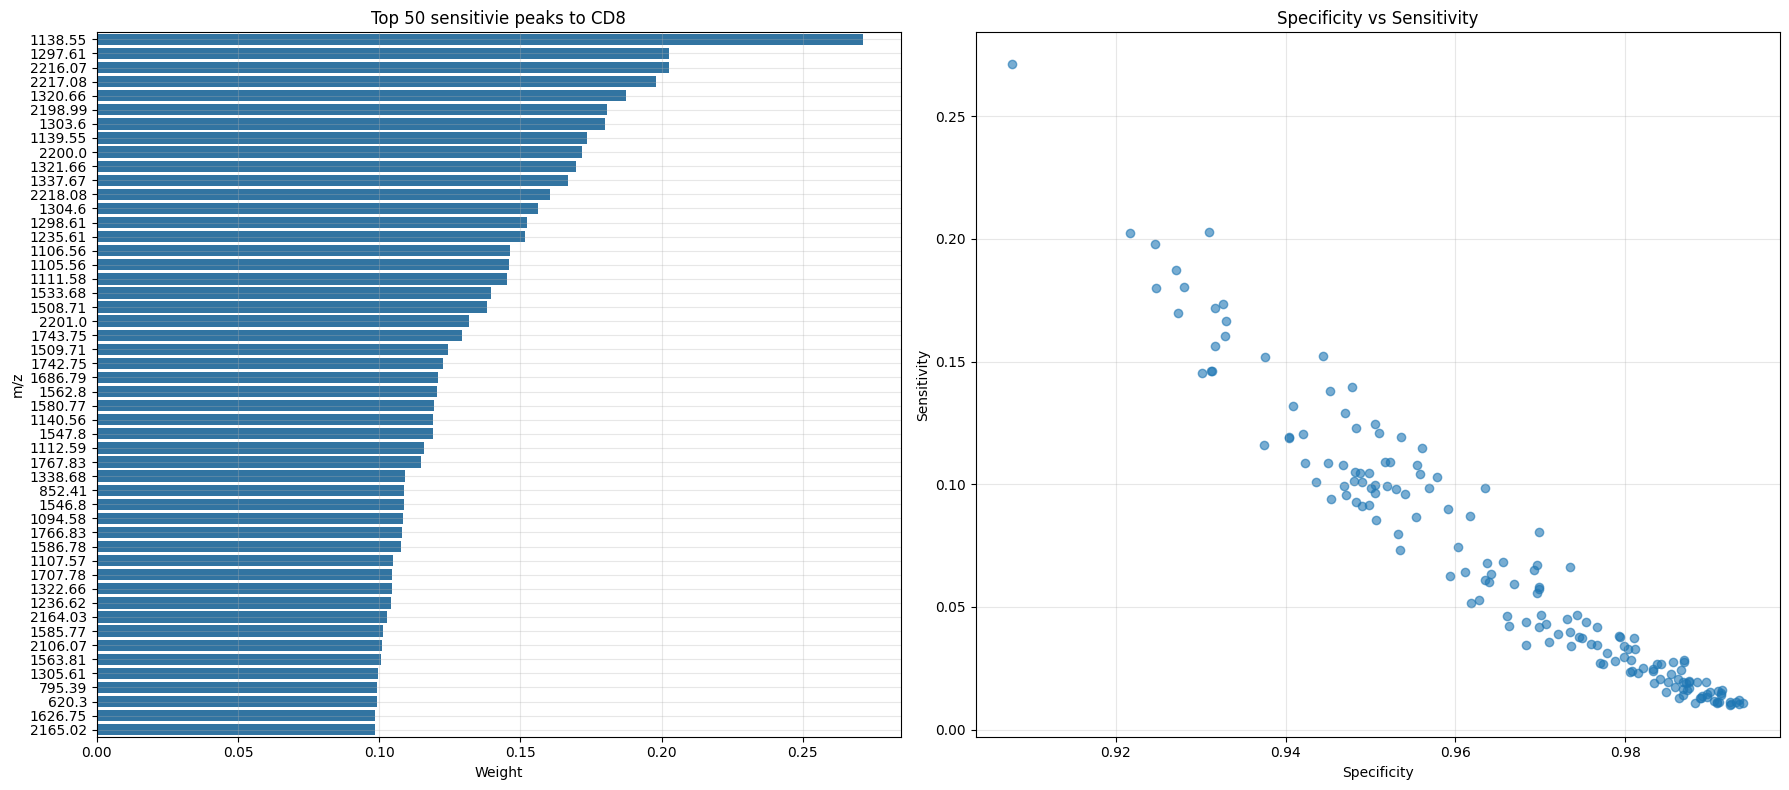

In [14]:
# Order the peaks by their Sensitivity to CD8
df_log_sensitive = df_log[df_log['Sensitivity'] > 0.01].sort_values(by='Sensitivity', ascending=False)

# Transform the mass data type to float
df_log_sensitive['mz'] = df_log_sensitive['mz'].astype(float).round(2).astype(str)

# Plot the top 50 peaks
fig, ax = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

sns.barplot(data=df_log_sensitive.head(50), x='Sensitivity', y='mz', orient="h", ax=ax[0])
ax[0].set_title("Top 50 sensitivie peaks to CD8")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("m/z")
ax[0].grid(alpha=0.3)

ax[1].scatter(df_log_sensitive['Specificity'], df_log_sensitive['Sensitivity'], alpha=0.6)
ax[1].set_title("Specificity vs Sensitivity")
ax[1].set_xlabel("Specificity")
ax[1].set_ylabel("Sensitivity")
ax[1].grid(alpha=0.3)

plt.show()

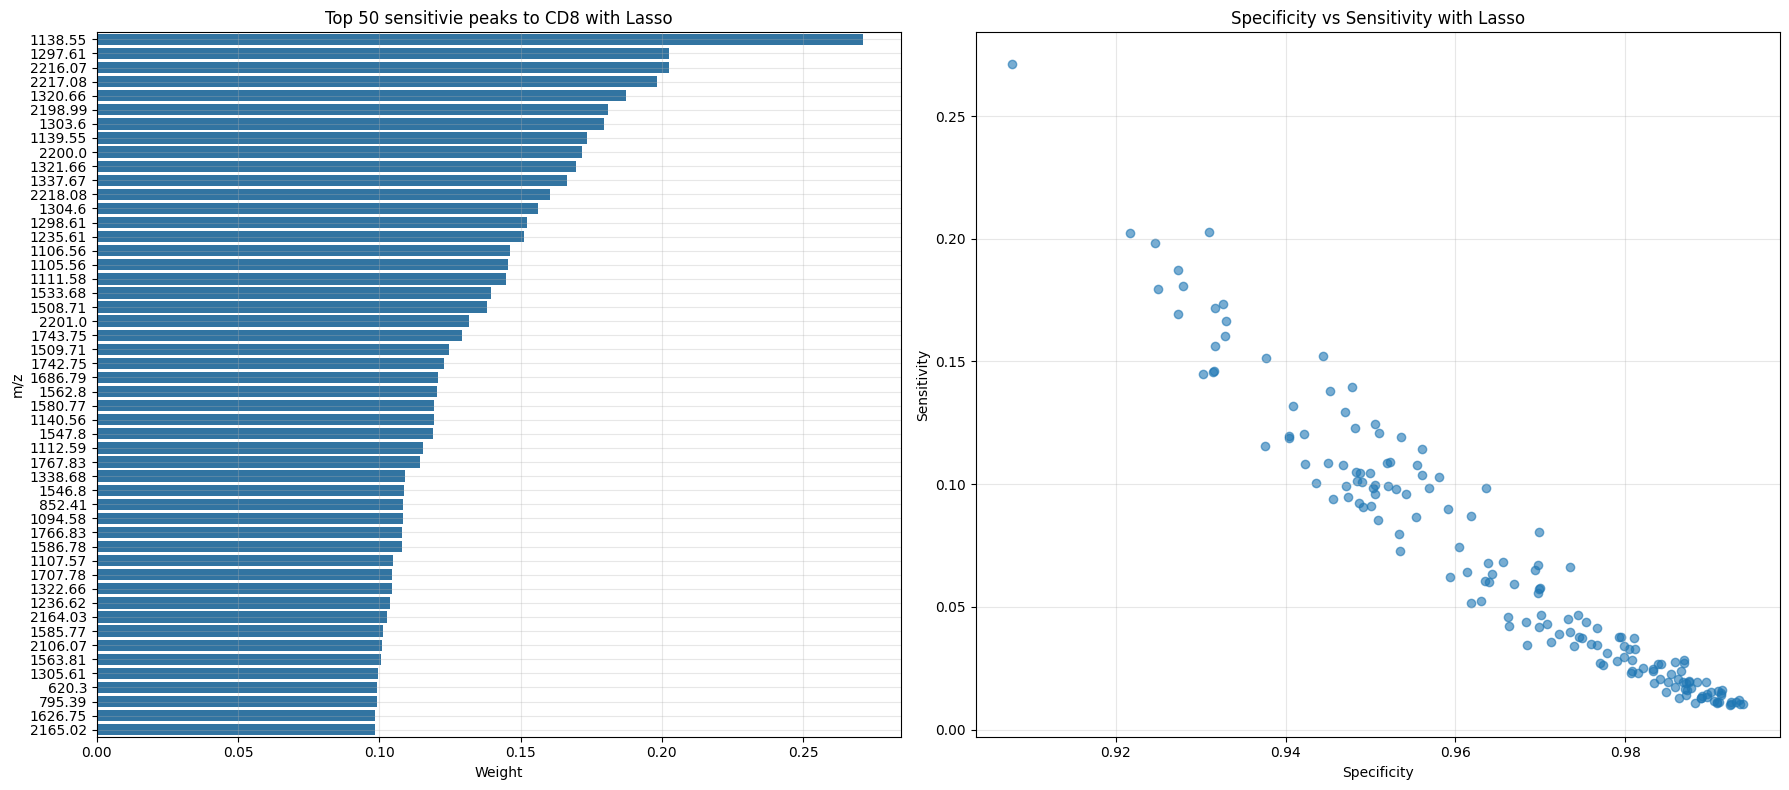

In [15]:
# Create a logistic regression model for each peak with lasso regularization
roc_aucs, sensitivities, specificities, precisions, precision_recall_aucs = [], [], [], [], []
for feature in X.T:
    # Reshape the data
    feature = feature.reshape(-1, 1)

    # Create a logistic regression model
    model_log = LogisticRegression(penalty='l1', solver='liblinear')

    # Train the model
    model_log.fit(feature, y)

    # Make predictions
    y_pred = model_log.predict(feature)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, model_log.predict_proba(feature)[:, 1])

    # Compute the ROC AUC
    roc_auc = roc_auc_score(y, model_log.predict_proba(feature)[:, 1])

    # Compute the True Positives, True Negatives, False Positives and False Negatives
    true_positives = np.sum((y == 1) & (y_pred == 1))
    true_negatives = np.sum((y == 0) & (y_pred == 0))
    false_positives = np.sum((y == 0) & (y_pred == 1))
    false_negatives = np.sum((y == 1) & (y_pred == 0))

    # Compute the Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    # Calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y, model_log.predict_proba(feature)[:, 1])

    # Compute the AUC for the precision-recall curve
    precision_recall_auc = auc(recall, precision)

    # Calculate the intersection threshold
    intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

    # Append the results
    roc_aucs.append(roc_auc)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    precisions.append(precision_recall_auc)
    precision_recall_aucs.append(precision_recall_auc)

# Create a dataframe with the results
df_log_lasso = pd.DataFrame({
    'mz': peaks.columns,
    'ROC_AUC': roc_aucs,
    'Sensitivity': sensitivities,
    'Specificity': specificities,
    'Precision': precisions,
    'Precision_Recall_AUC': precision_recall_aucs
})

# Order the peaks by their Sensitivity to CD8
df_log_lasso_sensitive = df_log_lasso[df_log_lasso['Sensitivity'] > 0.01].sort_values(by='Sensitivity', ascending=False)

# Transform the mass data type to float
df_log_lasso_sensitive['mz'] = df_log_lasso_sensitive['mz'].astype(float).round(2).astype(str)

# Plot the top 50 peaks
fig, ax = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

sns.barplot(data=df_log_lasso_sensitive.head(50), x='Sensitivity', y='mz', orient="h", ax=ax[0])
ax[0].set_title("Top 50 sensitivie peaks to CD8 with Lasso")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("m/z")
ax[0].grid(alpha=0.3)

ax[1].scatter(df_log_lasso_sensitive['Specificity'], df_log_lasso_sensitive['Sensitivity'], alpha=0.6)
ax[1].set_title("Specificity vs Sensitivity with Lasso")
ax[1].set_xlabel("Specificity")
ax[1].set_ylabel("Sensitivity")
ax[1].grid(alpha=0.3)

plt.show()